In [238]:
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as vutils

from PIL import Image

import random
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Generator(nn.Module):
    def __init__(self):
        deconv = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False), # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False), # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False), # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False), # 32x32 -> 64x64
            nn.Tanh()
        )
        
        super(Generator, self).__init__()
        self.deconv = deconv
        
    def forward(self, x):
        out = self.deconv(x)
        return out

In [3]:
class Descriminator(nn.Module):
    def __init__(self):
        conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False), # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False), # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False), # 16x16 -> 8x8
            nn.BatchNorm2d(256),     
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False), # 8x8 -> 4x4
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
        super(Descriminator, self).__init__()
        self.conv = conv
        
    def forward(self, x):
        out = self.conv(x).view(-1, 1) # 1
        return out

In [4]:
G = Generator().to(device)

# pretend input like [batch_size, num_cards, card_x, card_y], where card_x = card_y = 1 
noise = torch.randn(1, 100, 1, 1, device=device)
fake_images = G(noise)
fake_images.detach().shape

torch.Size([1, 3, 64, 64])

In [5]:
D = Descriminator().to(device)

gan_out = D(fake_images)
gan_out.shape

torch.Size([1, 1])

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
G.apply(weights_init)
D.apply(weights_init)

Descriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)

In [8]:
prepare = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [9]:
batch_size = 128
def batch_load(indices):
    batch = torch.zeros(batch_size, 3, 64, 64, device=device)
    
    for i in range(batch_size):
        image = Image.open('data/img_align_celeba/' + str(indices[i] + 1).zfill(6) + '.jpg')
        batch[i] = prepare(image)
        
    return batch

def gen_indices(train_size):
    return np.random.permutation(train_size)

In [10]:
criterion = nn.BCELoss()

# find global loss pit with Adam optimizer
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999)) # beta ?
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999)) # beta ?

In [11]:
train_size = 202599
train_step = train_size // batch_size
for epoch in range(2):
    loss_D = 0
    loss_G = 0
    indices = gen_indices(train_size)
    
    for i in range(train_step):
        batch = batch_load(indices[i * batch_size:(i + 1) * batch_size])
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = G(noise)
        
        # we construct compute graph above D net
        # ".detach()" uses fake_images without grad. Means "G_out is constant but not the result of some network matrxes to be propogated"
        loss = criterion(D(batch), torch.ones(batch_size, 1, device=device)) + criterion(D(fake_images.detach()), torch.zeros(batch_size, 1, device=device))
        optimizerD.zero_grad()
        loss.backward()
        optimizerD.step()
        loss_D = loss.detach()
    
    # for i in range(train_step):
        loss = criterion(D(fake_images), torch.ones(batch_size, 1, device=device)) # construct graph # true labels!
        optimizerG.zero_grad()
        loss.backward()
        optimizerG.step()
        loss_G = loss.detach()
        
        if (i % 50 == 0):
            print('Epoch: {} D Loss: {} G Loss: {}'.format(epoch, loss_D, loss_G))
    
    

Epoch: 0 D Loss: 1.6449600458145142 G Loss: 6.291982650756836
Epoch: 0 D Loss: 0.4847504198551178 G Loss: 15.77629566192627
Epoch: 0 D Loss: 0.0005615236004814506 G Loss: 35.153934478759766
Epoch: 0 D Loss: 0.0004513389721978456 G Loss: 49.98755645751953
Epoch: 0 D Loss: 0.00011018136865459383 G Loss: 48.663543701171875
Epoch: 0 D Loss: 6.20716527919285e-05 G Loss: 48.2857780456543
Epoch: 0 D Loss: 0.0042892335914075375 G Loss: 47.9092903137207
Epoch: 0 D Loss: 8.293335667985957e-06 G Loss: 47.12891387939453
Epoch: 0 D Loss: 0.00010566445416770875 G Loss: 47.096351623535156
Epoch: 0 D Loss: 4.5781140215694904e-05 G Loss: 47.12688446044922
Epoch: 0 D Loss: 1.5748441001051106e-05 G Loss: 47.00023651123047
Epoch: 0 D Loss: 6.159242275316501e-06 G Loss: 46.98877716064453
Epoch: 0 D Loss: 7.322392775677145e-05 G Loss: 46.921600341796875
Epoch: 0 D Loss: 9.414214218850248e-06 G Loss: 46.87548828125
Epoch: 0 D Loss: 0.0002381038648309186 G Loss: 46.72182083129883
Epoch: 0 D Loss: 4.4957960199

In [65]:
train_size = 202599
train_step = train_size // batch_size
for epoch in range(3):
    loss_D = 0
    loss_G = 0
    indices = gen_indices(train_size)
    
    for i in range(train_step):
        batch = batch_load(indices[i * batch_size:(i + 1) * batch_size])
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = G(noise)
        
        # we construct compute graph above D net
        # ".detach()" uses fake_images without grad. Means "G_out is constant but not the result of some network matrxes to be propogated"
        loss = criterion(D(batch), torch.ones(batch_size, 1, device=device)) + criterion(D(fake_images.detach()), torch.zeros(batch_size, 1, device=device))
        optimizerD.zero_grad()
        loss.backward()
        optimizerD.step()
        loss_D = loss.detach()
    
    # for i in range(train_step):
        loss = criterion(D(fake_images), torch.ones(batch_size, 1, device=device)) # construct graph # true labels!
        optimizerG.zero_grad()
        loss.backward()
        optimizerG.step()
        loss_G = loss.detach()
        
        if (i % 50 == 0):
            print('Epoch: {} D Loss: {} G Loss: {}'.format(epoch, loss_D, loss_G))
    
    

Epoch: 0 D Loss: 0.810631275177002 G Loss: 2.9950666427612305
Epoch: 0 D Loss: 0.7696955800056458 G Loss: 2.3729825019836426
Epoch: 0 D Loss: 0.9972043633460999 G Loss: 0.9101253747940063
Epoch: 0 D Loss: 0.8386455774307251 G Loss: 1.823049545288086
Epoch: 0 D Loss: 1.1382273435592651 G Loss: 0.9742949604988098
Epoch: 0 D Loss: 1.4208961725234985 G Loss: 0.6047199964523315
Epoch: 0 D Loss: 1.0365841388702393 G Loss: 2.162832021713257
Epoch: 0 D Loss: 0.71916663646698 G Loss: 3.054180145263672
Epoch: 0 D Loss: 0.6748275756835938 G Loss: 1.6200361251831055
Epoch: 0 D Loss: 0.992597222328186 G Loss: 3.827787399291992
Epoch: 0 D Loss: 1.4082913398742676 G Loss: 4.863868713378906
Epoch: 0 D Loss: 0.7577177882194519 G Loss: 2.943236827850342
Epoch: 0 D Loss: 1.0779836177825928 G Loss: 2.9185092449188232
Epoch: 0 D Loss: 0.7779419422149658 G Loss: 1.6160268783569336
Epoch: 0 D Loss: 1.1685879230499268 G Loss: 1.484604835510254
Epoch: 0 D Loss: 0.6346577405929565 G Loss: 1.8802989721298218
Epo

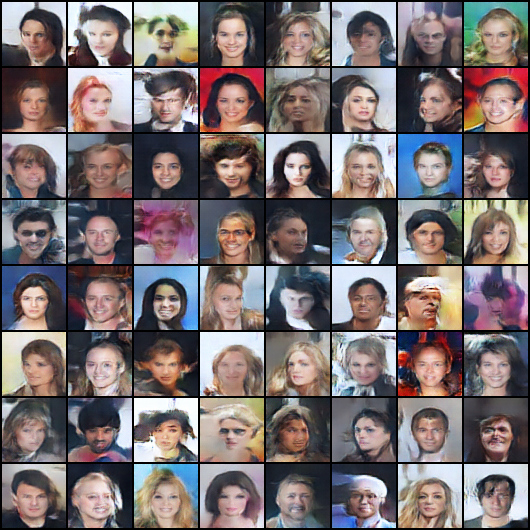

In [243]:
torch.save(D.state_dict(), 'D_torch_gpu')
torch.save(G.state_dict(), 'G_torch_gpu')

noise = torch.randn(64, 100, 1, 1, device=device)
fake_images = G(noise)
images = vutils.make_grid(fake_images.cpu().detach(), padding=2, normalize=True)

tensor_to_PIL = torchvision.transforms.ToPILImage()
tensor_to_PIL(images)

In [127]:
D_cpu = D.to('cpu')
G_cpu = G.to('cpu')

torch.save(D_cpu.state_dict(), 'D_torch_cpu')
torch.save(G_cpu.state_dict(), 'G_torch_cpu')